In [1]:
# imports
from itertools import combinations
from scipy import stats
import vae_utils as vae_utils
import random
# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE, RFECV, SequentialFeatureSelector
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score, mean_squared_error, silhouette_score, silhouette_samples
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn_extra.cluster import KMedoids
import upsetplot as uplt

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import matplotlib.cm as cm

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml
import upsetplot as uplt
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [21]:
protein_columns = pd.read_csv("NSAF_50.csv", index_col = "assay_id").columns

In [12]:
# Load datasets
data_combat = pd.read_csv("combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

labels = np.array(meta.Group)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [5]:
#mmi_quant = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_quant = uml.LowestValueImputerGaussian()
mmi_quant.fit(data_quantile, labels)
imputed_df_quant = mmi_quant.transform(data_quantile, labels)
mm_scaler = MinMaxScaler()
minmax_df_quant = mm_scaler.fit_transform(imputed_df_quant)

In [ ]:
# Perform feature selection
fs = uml.FeatureSelector(selectors="anova MI LR SVC".split(), num_features=100, threshold=.75)
fs_quant = fs.fit_transform(minmax_df_quant, targets)

In [4]:
# Load oversamplers

smote = SMOTE()
smotetomek = SMOTETomek()
smoteenn = SMOTEENN()
vae_ = vae_utils.VariationalAutoencoder(10, 2615, 500)
vae_filtered = vae_utils.VariationalAutoencoder(6, 161, 50)

vae_.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model"))
vae_filtered.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

<All keys matched successfully>

---

In [6]:
# Resample samples (no feature selection)
smote_quant_all, smote_y_all = smote.fit_resample(minmax_df_quant, targets)
smotetomek_quant_all, smotetomek_y_all = smotetomek.fit_resample(minmax_df_quant, targets)
smoteenn_quant_all, smoteenn_y_all = smoteenn.fit_resample(minmax_df_quant, targets)


vae_quant = vae_utils.resampleVAE(vae_, minmax_df_quant.astype("float32"), targets, n=1)
vae_resampled, vae_y = vae_quant

Minority: 100; Goal: 100
Reconstructing 982 datapoints...
Reconstructed 500/982
Resampled from VAE


In [7]:
smote_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(smote_quant_all)]).duplicated()[518:]
smotetomek_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(smotetomek_quant_all)]).duplicated()[518:]
smoteenn_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(smoteenn_quant_all)]).duplicated()[518:]

In [8]:
# Extract original samples from the SMOTE resampled datasets
smote_resampled = pd.DataFrame(smote_quant_all).loc[~smote_og_mask]
smotetomek_resampled = pd.DataFrame(smotetomek_quant_all).loc[~smotetomek_og_mask]
smoteenn_resampled = pd.DataFrame(smoteenn_quant_all).loc[~smoteenn_og_mask]

# ... along with the labels
smote_y_resampled = smote_y_all[~smote_og_mask]
smotetomek_y_resampled = smotetomek_y_all[~smotetomek_og_mask]
smoteenn_y_resampled = smoteenn_y_all[~smoteenn_og_mask]

In [9]:
# Create dataframes whereby first 518 entries are the original samples

smote_dataset = pd.concat([pd.DataFrame(minmax_df_quant), smote_resampled])
smotetomek_dataset = pd.concat([pd.DataFrame(minmax_df_quant), smotetomek_resampled])
smoteenn_dataset = pd.concat([pd.DataFrame(minmax_df_quant), smoteenn_resampled])
vae_dataset = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(vae_resampled)])

In [10]:
# Rescale the data

smote_resampled_rescaled = pd.DataFrame(mm_scaler.inverse_transform(smote_resampled))
smotetomek_resampled_rescaled = pd.DataFrame(mm_scaler.inverse_transform(smotetomek_resampled))
smoteenn_resampled_rescaled = pd.DataFrame(mm_scaler.inverse_transform(smoteenn_resampled))
vae_resampled_rescaled = pd.DataFrame(mm_scaler.inverse_transform(vae_resampled))

## Evaluate change in feature selection before and after each feature selection method

In [11]:
with open("selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]

feature_mask = protein_columns.isin(features)

filtered_dataset = imputed_df_quant.loc[:,feature_mask]

In [12]:
# Run this last
selected_features = {"Original": set(filtered_dataset.columns)}

annot = ["SMOTE", "SMOTETomek", "SMOTEENN", "VAE"]
resampled_datasets = [smote_resampled_rescaled, smotetomek_resampled_rescaled, smoteenn_resampled_rescaled, vae_resampled_rescaled]
labels_datasets = [smote_y_resampled, smotetomek_y_resampled, smoteenn_y_resampled, vae_y]

fs_ = uml.FeatureSelector(selectors=["LR", "SVC", "RF", "anova", "MI"], threshold=.5, num_features=300)

for i, oversampler in enumerate(annot):

    selection = fs_.fit_transform(resampled_datasets[i], labels_datasets[i])
    selected_features[oversampler] = set(selection.columns)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fa66d534450>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fa66d4cea50>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fa66d606690>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fa627bc77d0>}

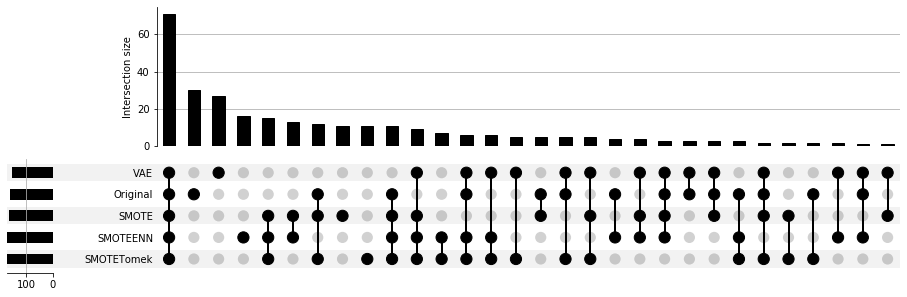

In [14]:
contents = uplt.from_contents(contents = selected_features)
uplt.plot(contents, sort_by="cardinality")

In [30]:
for i in selected_features.values():
    print(len(running_intersection)/len(list(i)))

0.4409937888198758
0.4251497005988024
0.4127906976744186
0.4152046783625731
0.46405228758169936


In [26]:
running_intersection = set()
for x in selected_features.values():
    if running_intersection == set():
        running_intersection = x
    else:
        running_intersection = running_intersection.intersection(x)

In [28]:
len(running_intersection)/len(set([i for x in selected_features.values() for i in list(x)]))

0.24067796610169492

---

Resample to gain original group distribution. This will remove bias from group-specific protein distibutions.

In [ ]:
# Resample so each class count is doubled
smote_comp = SMOTE(sampling_strategy={x: (targets==x).sum()*2 for x in np.unique(targets)})
smote_quant_all_comp, smote_y_comp = smote_comp.fit_resample(minmax_df_quant, targets)

SMOTETomek_comp =SMOTETomek(sampling_strategy={x: (targets==x).sum()*2 for x in np.unique(targets)})
SMOTETomek_quant_all_comp, SMOTETomek_y_comp =SMOTETomek_comp.fit_resample(minmax_df_quant, targets)

SMOTEENN_comp =SMOTEENN(sampling_strategy={x: (targets==x).sum()*2 for x in np.unique(targets)})
SMOTEENN_quant_all_comp, SMOTEENN_y_comp =SMOTEENN_comp.fit_resample(minmax_df_quant, targets)

# Drop the original samples

smote_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(smote_quant_all_comp)]).duplicated()[518:]
smotetomek_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(SMOTETomek_quant_all_comp)]).duplicated()[518:]
smoteenn_og_mask = pd.concat([pd.DataFrame(minmax_df_quant), pd.DataFrame(SMOTEENN_quant_all_comp)]).duplicated()[518:]
# Extract original samples from the SMOTE resampled datasets
smote_resampled_comp = pd.DataFrame(smote_quant_all_comp).loc[~smote_og_mask]
smotetomek_resampled_comp = pd.DataFrame(SMOTETomek_quant_all_comp).loc[~smotetomek_og_mask]
smoteenn_resampled_comp = pd.DataFrame(SMOTEENN_quant_all_comp).loc[~smoteenn_og_mask]
# ... along with the labels
smote_y_resampled_comp = smote_y_comp[~smote_og_mask]
smotetomek_y_resampled_comp = SMOTETomek_y_comp[~smotetomek_og_mask]
smoteenn_y_resampled_comp = SMOTEENN_y_comp[~smoteenn_og_mask]

_, vae_resampled_comp = vae_utils.useVAE(vae_, minmax_df_quant.astype("float32"))

In [13]:
# Transform minmax values to their original shape

quant_scaler = MinMaxScaler()
quant_scaler.fit(imputed_df_quant)

rescaled_smote = pd.DataFrame(quant_scaler.inverse_transform(smote_resampled_comp))
rescaled_smotetomek = pd.DataFrame(quant_scaler.inverse_transform(smotetomek_resampled_comp))
rescaled_smoteenn = pd.DataFrame(quant_scaler.inverse_transform(smoteenn_resampled_comp))
rescaled_vae = pd.DataFrame(quant_scaler.inverse_transform(vae_resampled_comp))

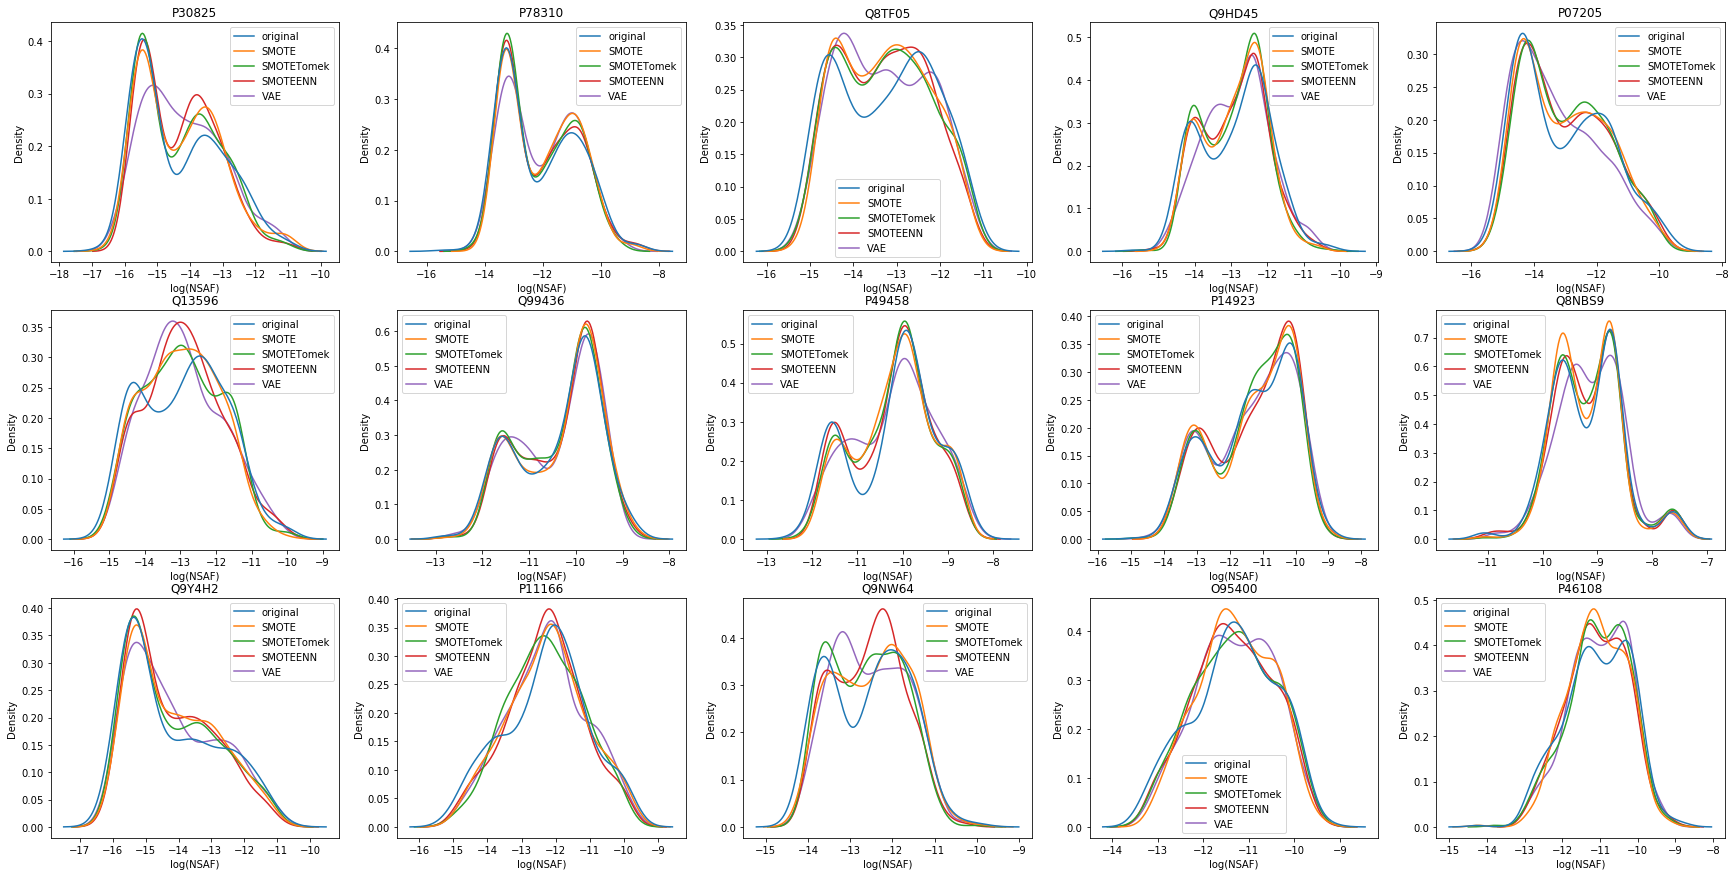

In [15]:
protein_indices = list(pd.DataFrame(minmax_df_quant).columns)
np.random.shuffle(protein_indices)

fig, ax = plt.subplots(3,5, figsize=(30,15))
for i,x in enumerate(protein_indices):
    ind=i
    c=0
    if i==15:
        break
    if i>9:
        c=2
        ind=ind-10
    elif i>4:
        c=1
        ind = ind-5

    dist_feature = pd.concat([imputed_df_quant.loc[:,x],
    rescaled_smote.loc[:,x].reset_index(drop=True),
    rescaled_smotetomek.loc[:,x].reset_index(drop=True),
    rescaled_smoteenn.loc[:,x].reset_index(drop=True),
    rescaled_vae.loc[:,x]], axis=1, ignore_index=True).rename(columns={0:"original", 1: "SMOTE", 2: "SMOTETomek", 3: "SMOTEENN", 4: "VAE"})

    sns.kdeplot(data=dist_feature, ax=ax[c,ind], common_norm=False)
    ax[c,ind].set_title(protein_columns[x])
    ax[c,ind].set_xlabel("log(NSAF)")

# Evaluate distribution, variance and mean of features

Same group distribution of original and resampled

In [14]:
ks_smote = []
ks_SMOTETomek = []
ks_enn = []
ks_vae = []

levene_smote = []
levene_SMOTETomek = []
levene_enn = []
levene_vae = []

t_smote = []
t_SMOTETomek = []
t_enn = []
t_vae = []

for x in pd.DataFrame(minmax_df_quant).columns:
    if x % 100 == 0:
        print(x)

    ks_smote.append(stats.ks_2samp(list(imputed_df_quant.loc[:,x]), list(rescaled_smote.loc[:,x])))
    ks_SMOTETomek.append(stats.ks_2samp(list(imputed_df_quant.loc[:,x]), list(rescaled_smotetomek.loc[:,x])))
    ks_enn.append(stats.ks_2samp(list(imputed_df_quant.loc[:,x]), list(rescaled_smoteenn.loc[:,x])))
    ks_vae.append(stats.ks_2samp(list(imputed_df_quant.loc[:,x]), list(rescaled_vae.loc[:,x])))

    levene_smote.append(stats.levene(list(imputed_df_quant.loc[:,x]), list(rescaled_smote.loc[:,x])))
    levene_SMOTETomek.append(stats.levene(list(imputed_df_quant.loc[:,x]), list(rescaled_smotetomek.loc[:,x])))
    levene_enn.append(stats.levene(list(imputed_df_quant.loc[:,x]), list(rescaled_smoteenn.loc[:,x])))
    levene_vae.append(stats.levene(list(imputed_df_quant.loc[:,x]), list(rescaled_vae.loc[:,x])))

    t_smote.append(stats.ttest_ind(list(imputed_df_quant.loc[:,x]), list(rescaled_smote.loc[:,x])))
    t_SMOTETomek.append(stats.ttest_ind(list(imputed_df_quant.loc[:,x]), list(rescaled_smotetomek.loc[:,x])))
    t_enn.append(stats.ttest_ind(list(imputed_df_quant.loc[:,x]), list(rescaled_smoteenn.loc[:,x])))
    t_vae.append(stats.ttest_ind(list(imputed_df_quant.loc[:,x]), list(rescaled_vae.loc[:,x])))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


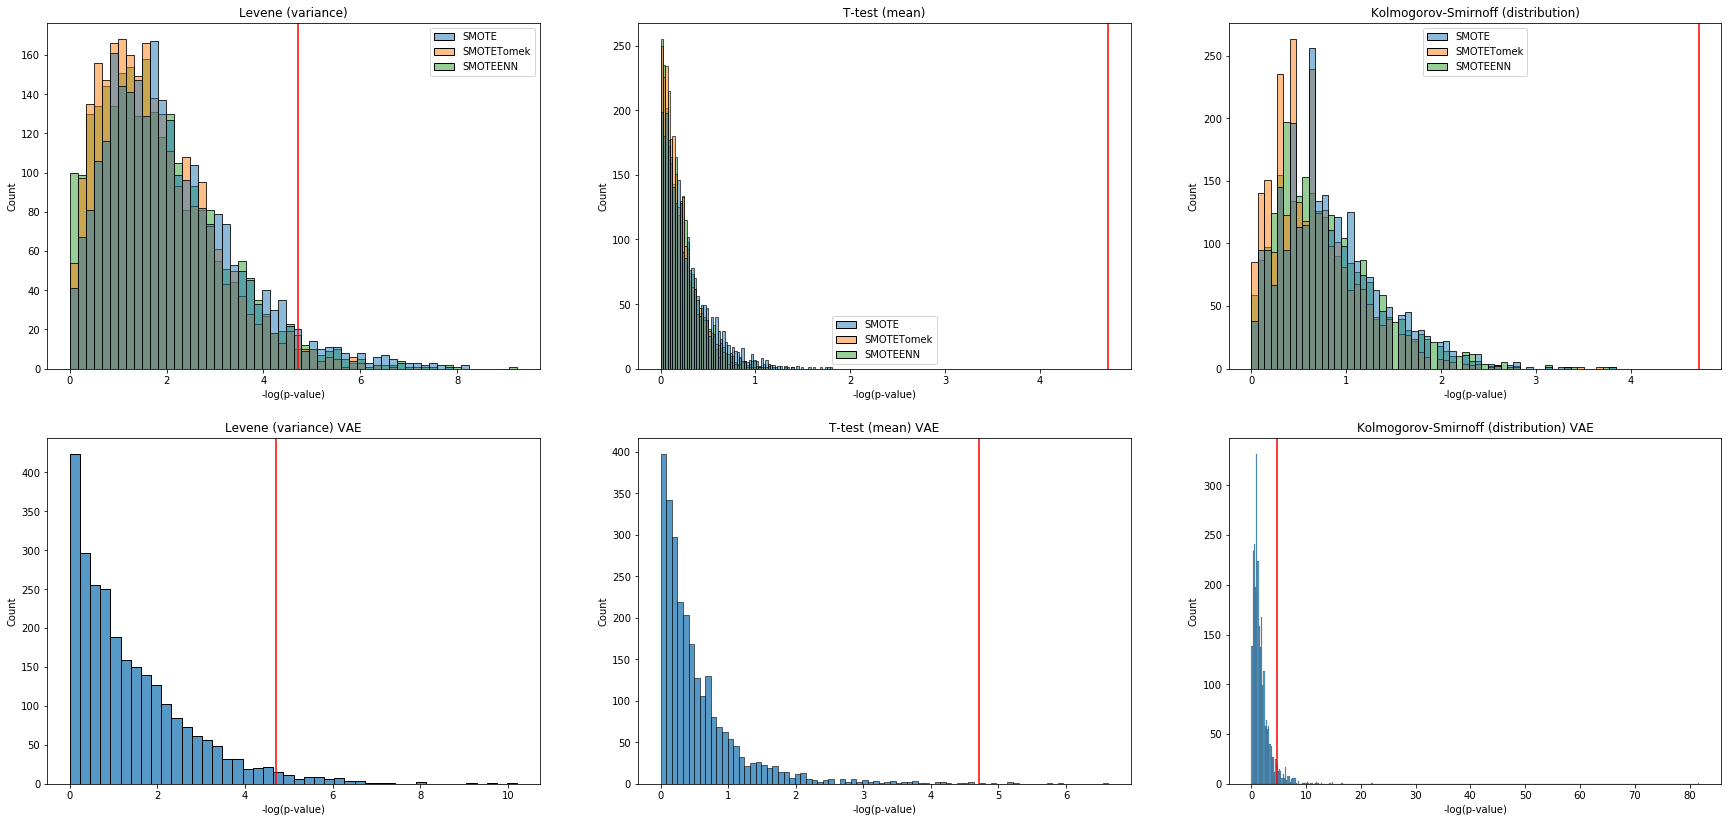

In [15]:
p_ks_smote = [-np.log10(x[1]) for x in ks_smote]
p_ks_SMOTETomek = [-np.log10(x[1]) for x in ks_SMOTETomek]
p_ks_smoteenn = [-np.log10(x[1]) for x in ks_enn]
p_ks_vae = [-np.log10(x[1]) for x in ks_vae]

p_levene_smote = [-np.log10(x[1]) for x in levene_smote]
p_levene_SMOTETomek = [-np.log10(x[1]) for x in levene_SMOTETomek]
p_levene_smoteenn = [-np.log10(x[1]) for x in levene_enn]
p_levene_vae = [-np.log10(x[1]) for x in levene_vae]

p_t_smote = [-np.log10(x[1]) for x in t_smote]
p_t_SMOTETomek = [-np.log10(x[1]) for x in t_SMOTETomek]
p_t_smoteenn = [-np.log10(x[1]) for x in t_enn]
p_t_vae = [-np.log10(x[1]) for x in t_vae]

p_ks = pd.DataFrame({"SMOTE": p_ks_smote, "SMOTETomek": p_ks_SMOTETomek, "SMOTEENN": p_ks_smoteenn})
p_levene = pd.DataFrame({"SMOTE": p_levene_smote, "SMOTETomek": p_levene_SMOTETomek, "SMOTEENN": p_levene_smoteenn})
p_t = pd.DataFrame({"SMOTE": p_t_smote, "SMOTETomek": p_t_SMOTETomek, "SMOTEENN": p_t_smoteenn})

fig, (ax,ax1) = plt.subplots(2,3, figsize=(30,14))

ax[0].set_title("Levene (variance)")
ax[1].set_title("T-test (mean)")
ax[2].set_title("Kolmogorov-Smirnoff (distribution)")

sns.histplot(data=p_levene, ax=ax[0])
ax[0].axvline(-np.log10(.05/2615), c="r")
sns.histplot(data=p_t, ax=ax[1])
ax[1].axvline(-np.log10(.05/2615), c="r")
sns.histplot(data=p_ks, ax=ax[2])
ax[2].axvline(-np.log10(.05/2615), c="r")

ax1[0].set_title("Levene (variance) VAE")
ax1[1].set_title("T-test (mean) VAE")
ax1[2].set_title("Kolmogorov-Smirnoff (distribution) VAE")

for i in range(3):
    ax[i].set_xlabel("-log(p-value)")
    ax1[i].set_xlabel("-log(p-value)")

sns.histplot(data=p_levene_vae, ax=ax1[0])
ax1[0].axvline(-np.log10(.05/2615), c="r")
sns.histplot(data=p_t_vae, ax=ax1[1])
ax1[1].axvline(-np.log10(.05/2615), c="r")
sns.histplot(data=p_ks_vae, ax=ax1[2])
ax1[2].axvline(-np.log10(.05/2615), c="r")

In [139]:
389/2615

0.14875717017208412

In [16]:
p_levene["VAE"] = p_levene_vae
(p_levene > -np.log10(.05/2615)).sum()

SMOTE         126
SMOTETomek     57
SMOTEENN       83
VAE            68
dtype: int64

In [17]:
diff_var_vae = p_levene.index[p_levene["VAE"] > -np.log10(0.05/2615)]
vae_var = rescaled_vae.loc[:,diff_var_vae].var()
og_var = imputed_df_quant.loc[:, diff_var_vae].var()

vae_var.name = "variance VAE"
og_var.name = "variance original"

In [18]:
vae_var = rescaled_vae.loc[:,diff_var_vae].var()
og_var = imputed_df_quant.loc[:, diff_var_vae].var()

vae_var.name = "variance VAE"
og_var.name = "variance original"

In [21]:
pd.concat([vae_var, og_var], axis=1).reset_index().melt(id_vars="index")

,index,variable,value
0,10,variance VAE,0.918371
1,20,variance VAE,1.424459
2,104,variance VAE,0.910411
3,142,variance VAE,1.015953
4,281,variance VAE,0.833818
...,...,...,...
93,2432,variance original,1.251887
94,2457,variance original,1.650529
95,2458,variance original,0.854590
96,2505,variance original,1.240501


Text(0.5, 0, 'Feature index')

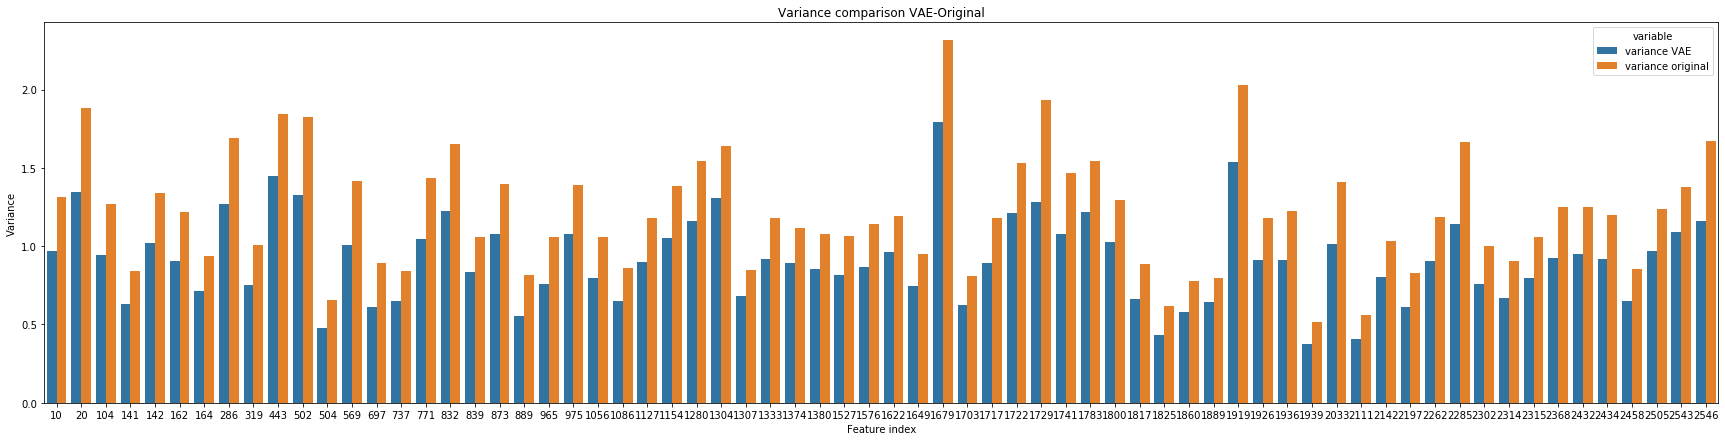

In [19]:
plt.figure(figsize=(30,7))

sns.barplot(data=pd.concat([vae_var, og_var], axis=1).reset_index().melt(id_vars="index"), x="index", y="value", hue="variable")
plt.title("Variance comparison VAE-Original")
plt.ylabel("Variance")
plt.xlabel("Feature index")

Text(0.5, 0, 'Feature index')

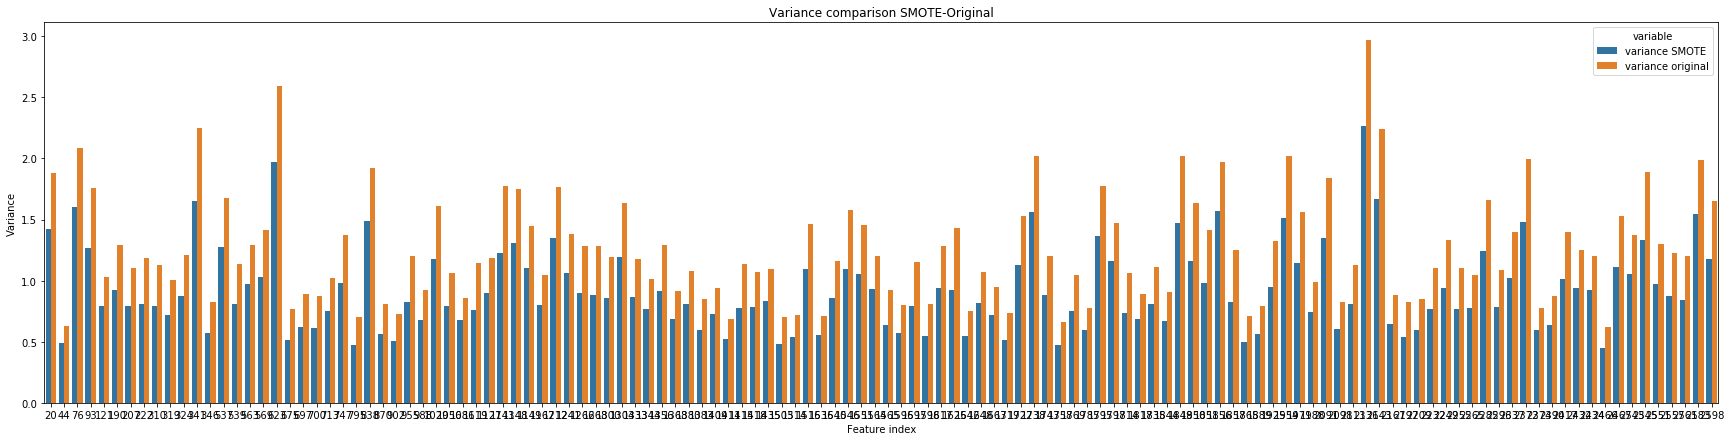

In [25]:
diff_var_smote = p_levene.index[p_levene["SMOTE"] > -np.log10(0.05/2615)]
smote_var = rescaled_smote.loc[:,diff_var_smote].var()
og_var = imputed_df_quant.loc[:, diff_var_smote].var()

smote_var.name = "variance SMOTE"
og_var.name = "variance original"

plt.figure(figsize=(30,7))

sns.barplot(data=pd.concat([smote_var, og_var], axis=1).reset_index().melt(id_vars="index"), x="index", y="value", hue="variable")
plt.title("Variance comparison SMOTE-Original")
plt.ylabel("Variance")
plt.xlabel("Feature index")

In [21]:
p_ks["VAE"] = p_ks_vae
(p_ks > -np.log10(.05/2615)).sum()

SMOTE           0
SMOTETomek      0
SMOTEENN        0
VAE           154
dtype: int64

In [24]:
p_ks["VAE"].sort_values(ascending=False)

933     81.132584
464     24.655672
1510    13.784910
1729    13.565070
702     13.565070
          ...    
733      0.015006
168      0.015006
2342     0.015006
373      0.007962
1471     0.003651
Name: VAE, Length: 2615, dtype: float64

In [22]:
diff_ks_vae = p_ks.index[p_ks["VAE"] > -np.log10(0.05/2615)]

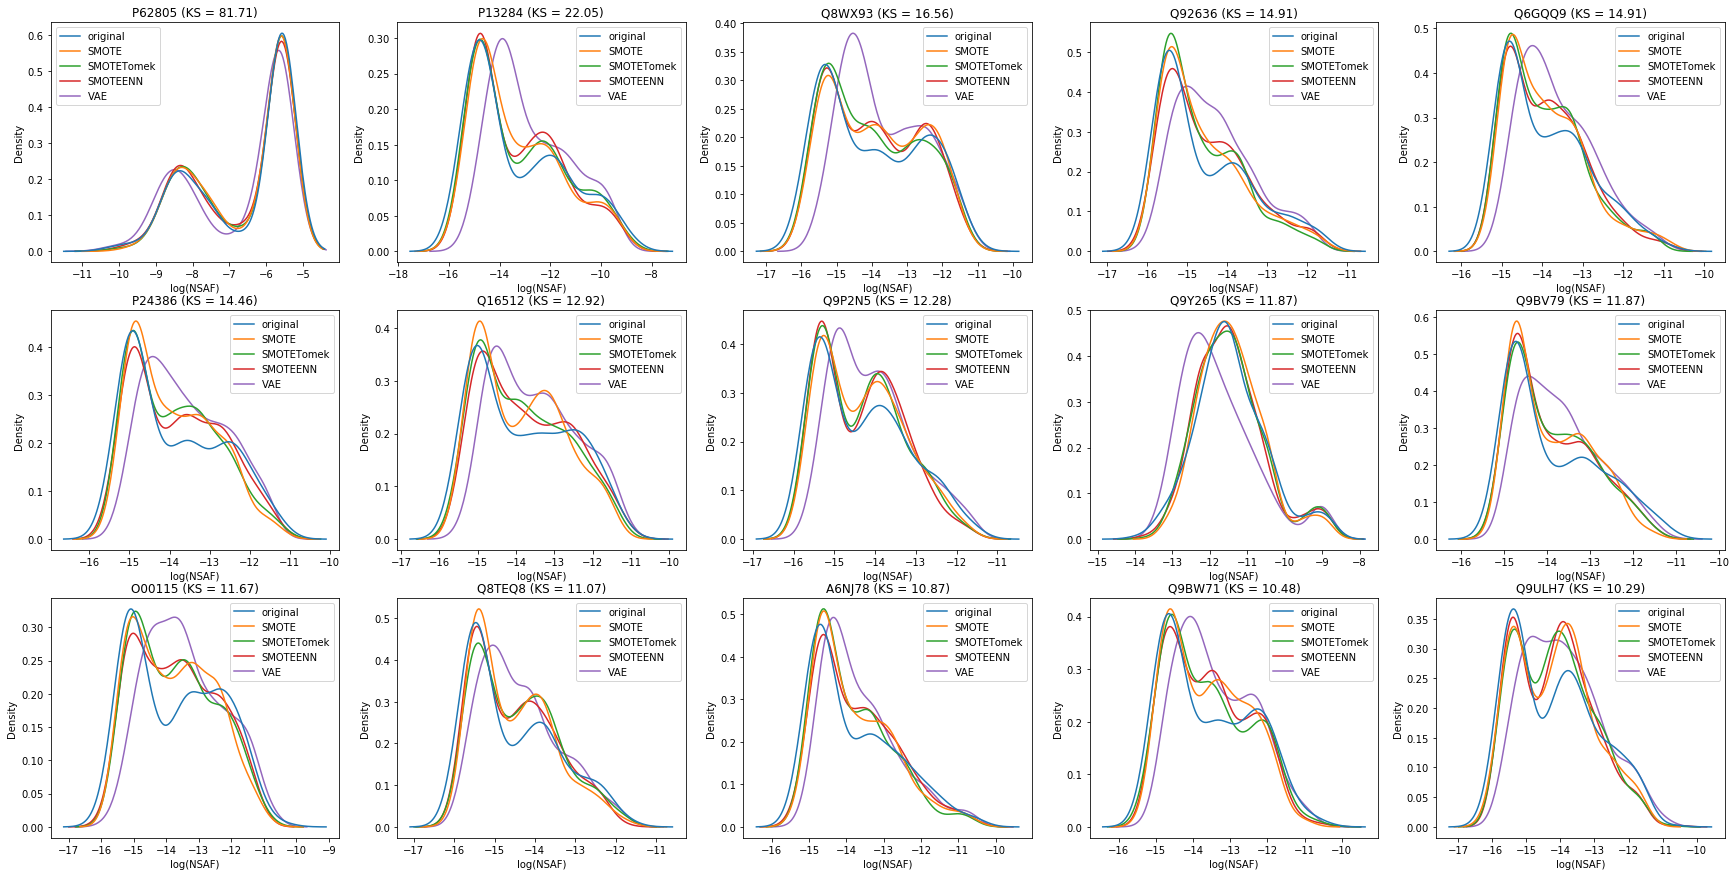

In [23]:
protein_indices = p_ks["VAE"].sort_values(ascending=False).index[:15]

fig, ax = plt.subplots(3,5, figsize=(30,15))
for i,x in enumerate(protein_indices):
    ind=i
    c=0
    if i==15:
        break
    if i>9:
        c=2
        ind=ind-10
    elif i>4:
        c=1
        ind = ind-5

    dist_feature = pd.concat([imputed_df_quant.loc[:,x],
    rescaled_smote.loc[:,x].reset_index(drop=True),
    rescaled_smotetomek.loc[:,x].reset_index(drop=True),
    rescaled_smoteenn.loc[:,x].reset_index(drop=True),
    rescaled_vae.loc[:,x]], axis=1, ignore_index=True).rename(columns={0:"original", 1: "SMOTE", 2: "SMOTETomek", 3: "SMOTEENN", 4: "VAE"})

    sns.kdeplot(data=dist_feature, ax=ax[c,ind], common_norm=False)
    ax[c,ind].set_title("{} (KS = {:.2f})".format(protein_columns[x], p_ks.loc[x, "VAE"]))
    ax[c,ind].set_xlabel("log(NSAF)")

In [24]:
p_t["VAE"] = p_t_vae
(p_t > -np.log10(.05/2615)).sum()

SMOTE         0
SMOTETomek    0
SMOTEENN      0
VAE           8
dtype: int64

In [27]:
{  "SMOTETomek": [set(protein_columns[np.array(p_levene_SMOTETomek) > -np.log10(.05/2615)]), np.array(p_levene_SMOTETomek)[np.array(p_levene_SMOTETomek) > -np.log10(.05/2615)]],
   "SMOTE": [set(protein_columns[np.array(p_levene_smote) > -np.log10(.05/2615)]), np.array(p_levene_smote)[np.array(p_levene_smote) > -np.log10(.05/2615)]],
   "SMOTEENN": [set(protein_columns[np.array(p_levene_smoteenn) > -np.log10(.05/2615)]), np.array(p_levene_smoteenn)[np.array(p_levene_smoteenn) > -np.log10(.05/2615)]]}

{'SMOTETomek': [{'O00330',
   'O14802',
   'O15111',
   'O60725',
   'O75439',
   'O95168',
   'O95628',
   'O95721',
   'P00374',
   'P27482',
   'P29084',
   'P30613',
   'P35244',
   'P41214',
   'P46199',
   'P50748',
   'P51153',
   'P53384',
   'P57772',
   'P62745',
   'P78345',
   'Q00403',
   'Q01804',
   'Q15751',
   'Q3ZAQ7',
   'Q49AR2',
   'Q5MIZ7',
   'Q6NUQ1',
   'Q70CQ2',
   'Q86YV9',
   'Q8IY18',
   'Q8N122',
   'Q8N5M9',
   'Q8NC60',
   'Q8TAF3',
   'Q8TC07',
   'Q8WWC4',
   'Q8WWV3',
   'Q8WZA0',
   'Q92526',
   'Q96AQ6',
   'Q96CN9',
   'Q96DZ1',
   'Q96GA3',
   'Q96I51',
   'Q96S44',
   'Q96SZ5',
   'Q99808',
   'Q9BSL1',
   'Q9BXV9',
   'Q9H900',
   'Q9NRY2',
   'Q9NVT9',
   'Q9NVX2',
   'Q9NX20',
   'Q9P1U1',
   'Q9UID3',
   'Q9UJX5',
   'Q9Y263'},
  array([5.56579659, 4.95006379, 5.47922953, 4.77095767, 4.76427798,
         6.77323381, 6.50498087, 5.48703774, 6.48954218, 5.34244632,
         4.81131412, 4.85929243, 5.23342629, 5.40159348, 6.15061729,
         5.

---

# Global patterns after oversampling

In [26]:
colors = sns.color_palette("tab20")[:15]
colors = {target_encoder.inverse_transform([x])[0]: colors[x] for x in unique_labels}

In [36]:
pca1.explained_variance_

array([13.28439045,  9.15414134])

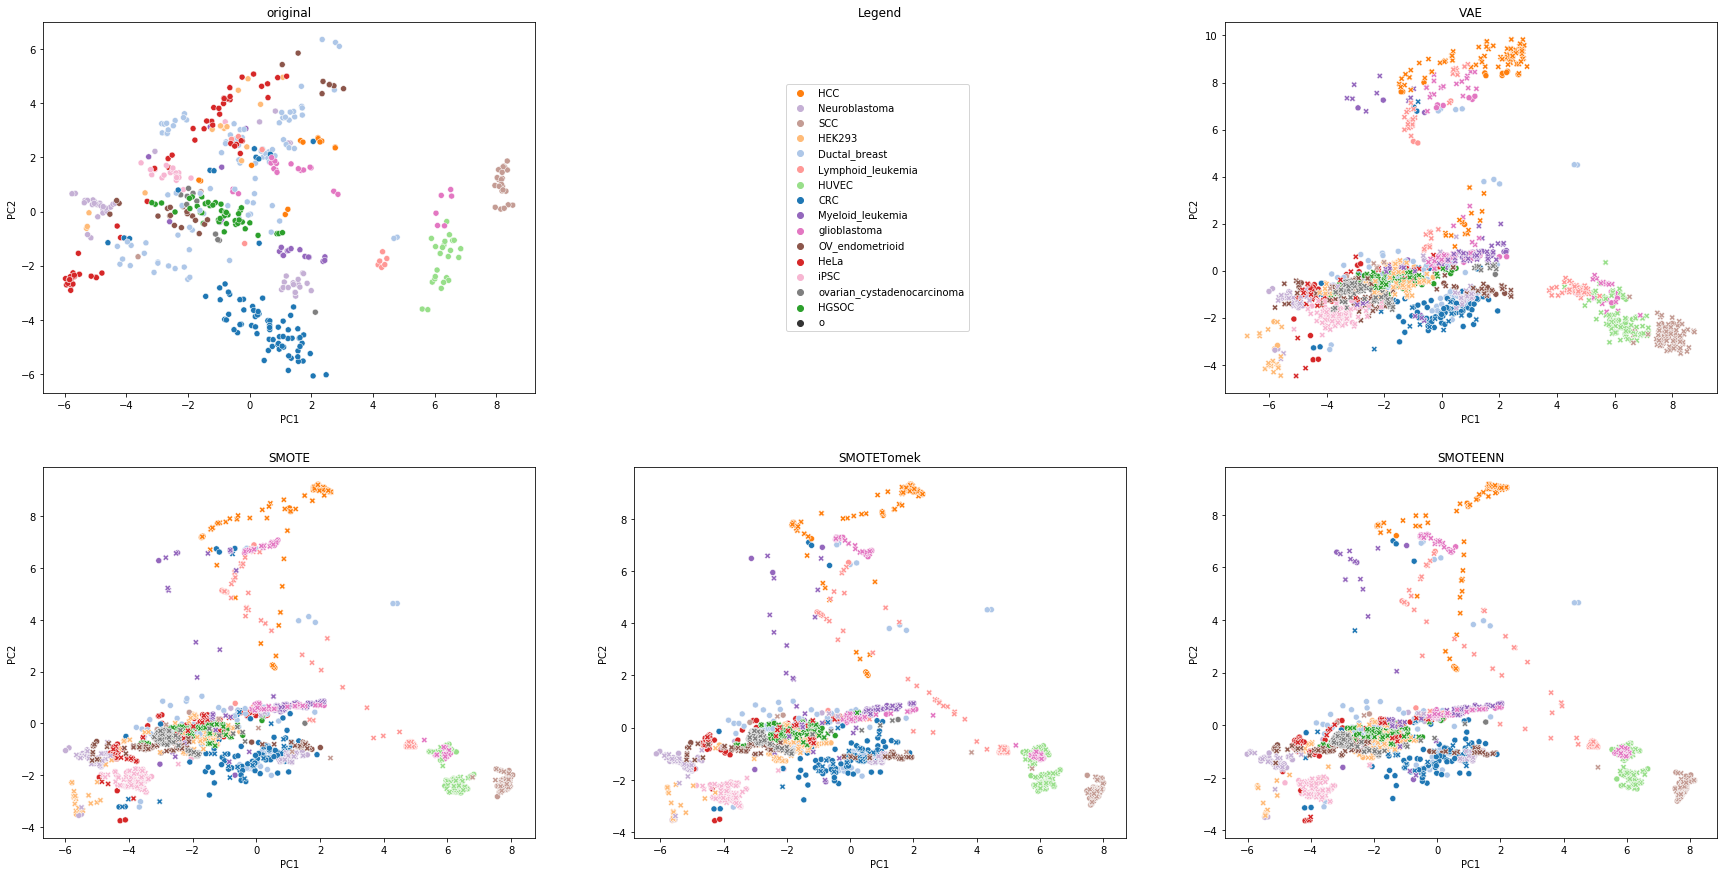

In [34]:
fig, (axi,ax) = plt.subplots(2,3, figsize=(30,15))

pca1 = PCA(n_components=2)

pca1.fit(minmax_df_quant)

axi[0].set_title("original")
axi[2].set_title("VAE")
axi[1].set_title("Legend")
ax[0].set_title("SMOTE")
ax[1].set_title("SMOTETomek")
ax[2].set_title("SMOTEENN")
axi[1].set_axis_off()

g=sns.scatterplot(data=pd.DataFrame(pca1.transform(minmax_df_quant), columns=["PC1","PC2"]), x="PC1", y="PC2", hue=target_encoder.inverse_transform(list(targets)), 
                style=['o']*518, palette=colors,ax=axi[0])
sns.move_legend(g, "center left", bbox_to_anchor=(1.5, .5))

sns.scatterplot(data=pd.DataFrame(pca1.transform(smote_dataset), columns=["PC1","PC2"]), x="PC1", y="PC2", hue=target_encoder.inverse_transform(list(targets)+list(smote_y_resampled)), 
                style=['o']*518+["x"]*len(smote_y_resampled), palette=colors,ax=ax[0], legend=False)

sns.scatterplot(data=pd.DataFrame(pca1.transform(smotetomek_dataset), columns=["PC1","PC2"]), x="PC1", y="PC2", hue=target_encoder.inverse_transform(list(targets)+list(smotetomek_y_resampled))
                , style=['o']*518+["x"]*len(smotetomek_y_resampled), palette=colors,ax=ax[1], legend=False)

sns.scatterplot(data=pd.DataFrame(pca1.transform(smoteenn_dataset), columns=["PC1","PC2"]), x="PC1", y="PC2", hue=target_encoder.inverse_transform(list(targets)+list(smoteenn_y_resampled))
                , style=['o']*518+["x"]*len(smoteenn_y_resampled), palette=colors,ax=ax[2], legend=False)

sns.scatterplot(data=pd.DataFrame(pca1.transform(vae_dataset), columns=["PC1","PC2"]), x="PC1", y="PC2", hue=target_encoder.inverse_transform(list(targets)+list(vae_y))
                , style=['o']*518+["x"]*len(vae_y), palette=colors,ax=axi[2], legend=False)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

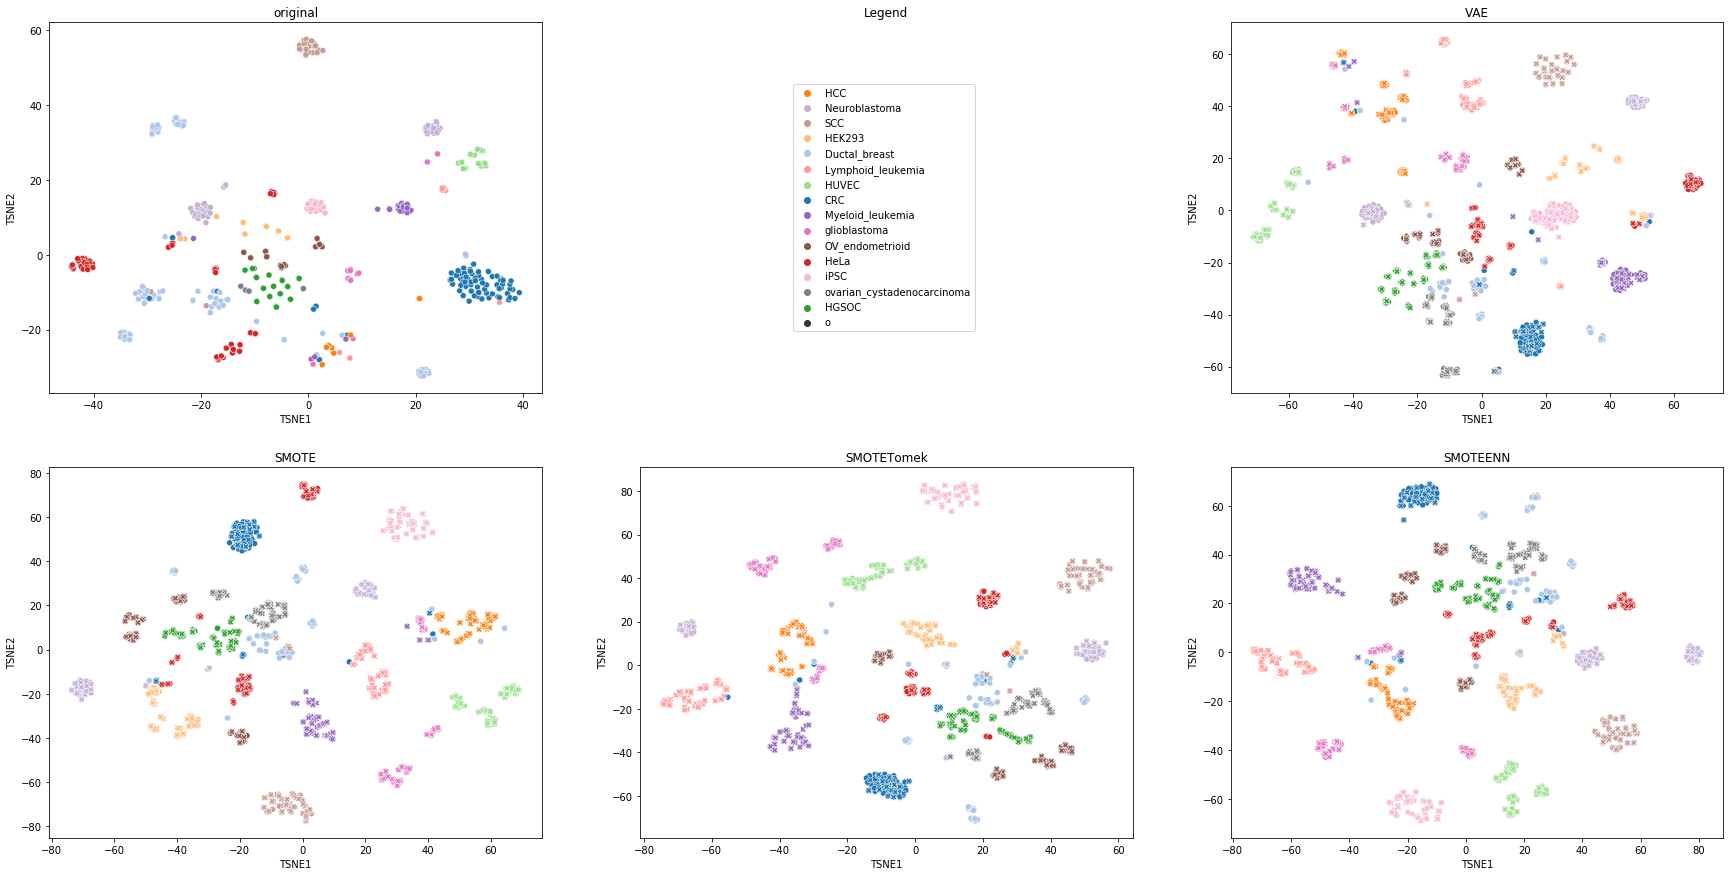

In [35]:
fig, (axi,ax) = plt.subplots(2,3, figsize=(30,15))

TSNEa1 = TSNE(perplexity=20)

TSNEa1.fit(minmax_df_quant)

axi[0].set_title("original")
axi[2].set_title("VAE")
axi[1].set_title("Legend")
ax[0].set_title("SMOTE")
ax[1].set_title("SMOTETomek")
ax[2].set_title("SMOTEENN")
axi[1].set_axis_off()
g=sns.scatterplot(data=pd.DataFrame(TSNEa1.fit_transform(minmax_df_quant), columns=["TSNE1","TSNE2"]), x="TSNE1", y="TSNE2", hue=target_encoder.inverse_transform(list(targets)), 
                style=['o']*518, palette=colors,ax=axi[0])
sns.move_legend(g, "center left", bbox_to_anchor=(1.5, .5))

sns.scatterplot(data=pd.DataFrame(TSNEa1.fit_transform(smote_dataset), columns=["TSNE1","TSNE2"]), x="TSNE1", y="TSNE2", hue=target_encoder.inverse_transform(list(targets)+list(smote_y_resampled)), 
                style=['o']*518+["x"]*len(smote_y_resampled), palette=colors,ax=ax[0], legend=False)

sns.scatterplot(data=pd.DataFrame(TSNEa1.fit_transform(smotetomek_dataset), columns=["TSNE1","TSNE2"]), x="TSNE1", y="TSNE2", hue=target_encoder.inverse_transform(list(targets)+list(smotetomek_y_resampled))
                , style=['o']*518+["x"]*len(smotetomek_y_resampled), palette=colors,ax=ax[1], legend=False)

sns.scatterplot(data=pd.DataFrame(TSNEa1.fit_transform(smoteenn_dataset), columns=["TSNE1","TSNE2"]), x="TSNE1", y="TSNE2", hue=target_encoder.inverse_transform(list(targets)+list(smoteenn_y_resampled))
                , style=['o']*518+["x"]*len(smoteenn_y_resampled), palette=colors,ax=ax[2], legend=False)

sns.scatterplot(data=pd.DataFrame(TSNEa1.fit_transform(vae_dataset), columns=["TSNE1","TSNE2"]), x="TSNE1", y="TSNE2", hue=target_encoder.inverse_transform(list(targets)+list(vae_y))
                , style=['o']*518+["x"]*len(vae_y), palette=colors,ax=axi[2], legend=False)

---

# Performance

In [7]:
performance = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/ML/results/oversampling_evaluation_final.csv", sep=";")
performance.head()

,model,fold,micro_f1,macro_f1,weighted_f1,cm,balancer,n_features
0,LogisticRegression,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,weights,161
1,LogisticRegression,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,SMOTE,161
2,LogisticRegression,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,SMOTETomek,161
3,LogisticRegression,1,0.980769,0.989084,0.981332,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,SMOTEENN,161
4,LogisticRegression,1,0.788462,0.828889,0.741667,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,VAE,161


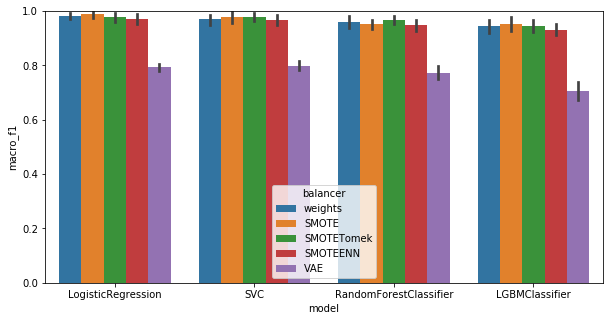

In [6]:
# Evalutation of oversamplers on filtered
plt.figure(figsize=(10,5))
plt.ylim((0,1))
sns.barplot(data=performance,x="model", hue="balancer", y="macro_f1")

In [8]:
performance.groupby(["model", "balancer"]).mean().macro_f1.sort_values(ascending=False)

model                   balancer  
LogisticRegression      SMOTE         0.987411
                        weights       0.983052
SVC                     SMOTETomek    0.978419
LogisticRegression      SMOTETomek    0.977749
SVC                     SMOTE         0.977657
LogisticRegression      SMOTEENN      0.972057
SVC                     weights       0.969762
                        SMOTEENN      0.966440
RandomForestClassifier  SMOTETomek    0.966006
                        weights       0.960980
LGBMClassifier          SMOTE         0.953521
RandomForestClassifier  SMOTE         0.951240
                        SMOTEENN      0.947927
LGBMClassifier          weights       0.945460
                        SMOTETomek    0.943653
                        SMOTEENN      0.931654
SVC                     VAE           0.797641
LogisticRegression      VAE           0.793426
RandomForestClassifier  VAE           0.773412
LGBMClassifier          VAE           0.706419
Name: macro_f1, dtype: fl

In [4]:
performance = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/ML/results/oversampling_evaluation_fs_after.csv", sep=";")
performance.head()

,model,fold,micro_f1,macro_f1,weighted_f1,cm,balancer,n_features
0,LogisticRegression,1,0.961538,0.979259,0.963248,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,weights,156
1,LogisticRegression,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,SMOTE,165
2,LogisticRegression,1,1.000000,1.000000,1.000000,[[ 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,SMOTETomek,174
3,LogisticRegression,1,0.865385,0.919728,0.869396,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,SMOTEENN,167
4,LogisticRegression,1,0.807692,0.816739,0.740010,[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,VAE,142


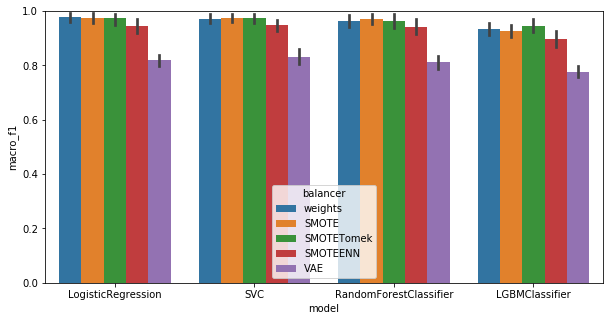

In [5]:
plt.figure(figsize=(10,5))
plt.ylim((0,1))
sns.barplot(data=performance,x="model", hue="balancer", y="macro_f1")

In [6]:
performance.groupby(["model", "balancer"]).mean().macro_f1.sort_values(ascending=False)

model                   balancer  
LogisticRegression      weights       0.976958
SVC                     SMOTE         0.975827
                        SMOTETomek    0.974240
LogisticRegression      SMOTE         0.973989
                        SMOTETomek    0.972748
RandomForestClassifier  SMOTE         0.972058
SVC                     weights       0.971898
RandomForestClassifier  SMOTETomek    0.965023
                        weights       0.963108
SVC                     SMOTEENN      0.947675
LGBMClassifier          SMOTETomek    0.946267
LogisticRegression      SMOTEENN      0.944274
RandomForestClassifier  SMOTEENN      0.941396
LGBMClassifier          weights       0.933539
                        SMOTE         0.925090
                        SMOTEENN      0.897770
SVC                     VAE           0.832184
LogisticRegression      VAE           0.820535
RandomForestClassifier  VAE           0.813191
LGBMClassifier          VAE           0.777252
Name: macro_f1, dtype: fl

# Is feature selection affected by oversampling?

Perform fs before oversampling

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

print("Reading data...")
data_quantile = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
protein_columns = data_quantile.columns
meta = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_quantile.index)]
groups = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_quantile.sort_index(inplace=True)
meta.sort_index(inplace=True)

with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]
data_quantile = data_quantile.loc[:, features]

data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})


target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

vae = vae_utils.VariationalAutoencoder(6, 161, 50)
vae.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

lr_clf = LogisticRegression(max_iter=10000)
svm_clf = SVC()
rf_clf = RandomForestClassifier()
lgbm_clf = lgbm()
models = [lr_clf, svm_clf, rf_clf, lgbm_clf]

param = {"class_weight": weights}
no_param = {"class_weight": None}

fold = 0
for train, test in skf.split(X=data_quantile, y=targets):
    fold+=1
    print(fold,"/10")
    X_train_quantile = data_quantile.iloc[train,:].reset_index(drop=True)
    X_test_quantile = data_quantile.iloc[test,:].reset_index(drop=True)

    Y_train = targets[train]
    Y_test = targets[test]

    # Imputation
    print("Imputing...")
    #imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
    imputer = uml.LowestValueImputerGaussian()
    imputer.fit(X_train_quantile, Y_train)
    imputed_train = imputer.transform(X_train_quantile, Y_train)
    imputed_test = imputer.transform(X_test_quantile)

    quant_scaler = MinMaxScaler()
    scaled_train = quant_scaler.fit_transform(imputed_train)
    scaled_test = quant_scaler.transform(imputed_test)
    scaled_train = scaled_train.astype("float32")
    scaled_test = scaled_test.astype("float32")
    
    # Oversampling
    print("Oversampling...")
    smote = SMOTE()
    smote_quant, smote_y = smote.fit_resample(scaled_train, Y_train)

    smotetomek = SMOTETomek()
    SMOTETomek_quant, SMOTETomek_y = smotetomek.fit_resample(scaled_train, Y_train)

    smoteenn = SMOTEENN()
    SMOTEENN_quant, SMOTEENN_y =smoteenn.fit_resample(scaled_train, Y_train)

    vae_quant, vae_y = vae_utils.resampleVAE(vae, scaled_train, Y_train, 1)

    annotation = ["weights", "SMOTE", "SMOTETomek", "SMOTEENN", "VAE"]

    X_train = [scaled_train, smote_quant, SMOTETomek_quant, SMOTEENN_quant, vae_quant]
    y = [Y_train, smote_y, SMOTETomek_y, SMOTEENN_y, vae_y]
    X_test = scaled_test

    for model in models:
        print("Training models...")
        for i, balancer in enumerate(annotation):

            if balancer == "weights":
                model.set_params(**param)
            else:
                model.set_params(**no_param)
            
            model.fit(X_train[i], y[i])
            y_pred = model.predict(X_test)

            micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=y_pred, Y_test=Y_test, labels=unique_labels)
            results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm],
                                        "balancer": [balancer], "n_features": [X_train[i].shape[1]]})
            uml.save_results(results_df, "oversampling_evaluation_fs_before")

Reading data...
{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}
1 /10
Imputing...
Oversampling...
Minority: 90; Goal: 90
Reconstructing 884 datapoints...
Reconstructed 500/884
Resampled from VAE
Training models...
Training models...
Training models...
Training models...
2 /10
Imputing...
Oversampling...
Minority: 90; Goal: 90
Reconstructing 884 datapoints...
Reconstructed 500/884
Resampled from VAE
Training models...
Training models...
Training models...
Training models...
3 /10
Imputing...
Oversampling...
Minority: 90; Goal: 90
Reconstructing 884 datapoints...
Reconstructed 500/884
Resampled from VAE
Training models...
Training models...
Training models...
Training models...
4 /10
Imputing.

In [4]:
fs_before = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/ML/results/oversampling_evaluation_fs_before.csv", sep=";")
fs_before.groupby(["balancer", "model"]).mean().macro_f1

balancer    model                 
SMOTE       LGBMClassifier            0.964896
            LogisticRegression        0.983348
            RandomForestClassifier    0.966588
            SVC                       0.980933
SMOTEENN    LGBMClassifier            0.933720
            LogisticRegression        0.967361
            RandomForestClassifier    0.942659
            SVC                       0.968199
SMOTETomek  LGBMClassifier            0.953782
            LogisticRegression        0.983477
            RandomForestClassifier    0.961050
            SVC                       0.977632
VAE         LGBMClassifier            0.716134
            LogisticRegression        0.797466
            RandomForestClassifier    0.767023
            SVC                       0.795875
weights     LGBMClassifier            0.940662
            LogisticRegression        0.984140
            RandomForestClassifier    0.962494
            SVC                       0.972220
Name: macro_f1, dtype: fl

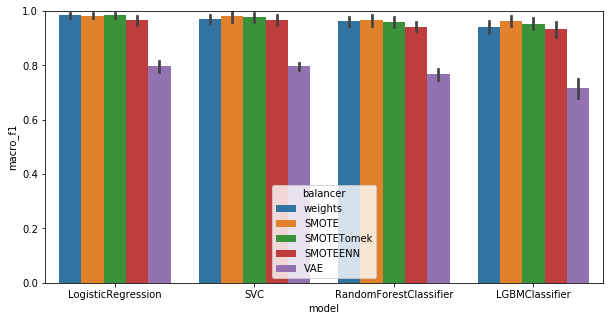

In [5]:
# Evalutation of oversamplers on filtered
plt.figure(figsize=(10,5))
plt.ylim((0,1))
sns.barplot(data=fs_before,x="model", hue="balancer", y="macro_f1")

---